In [1]:
import logging
import clip
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from skimage.io import imread, imsave
import torch
import torchvision

import forger.util.clip_util
from forger.util.logging import log_tensor, default_log_setup
from forger.viz.bundled import REPO_ROOT
import forger.viz.visualize
import forger.ui.library

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

logger = logging.getLogger(__name__)
default_log_setup(logging.INFO)
logging.getLogger('matplotlib.font_manager').setLevel(20)
logging.getLogger('matplotlib.axes._base').setLevel(20)
logging.getLogger('PIL.Image').setLevel(20)

2023-09-20 14:57:17,129|    INFO|forger.util.logging| Logging to stdout and None


In [2]:
import math 

def quick_viz(imgs, save_file=None, save_prefix=None, nrow=None):
    if nrow is None:
        nrow = imgs.shape[0]
    res = torchvision.utils.make_grid(imgs.detach(), nrow=nrow, padding=0).permute(1, 2, 0)
    res = (res * 255).clip(0, 255).to(torch.uint8).detach().cpu().numpy()
    fig = plt.figure()
    inches = 5
    fig.set_size_inches(nrow * inches, int(math.ceil(imgs.shape[0] / nrow)) * inches, forward=True)
    ax = fig.add_subplot(1, 2, 1)
    imgplot = plt.imshow(res)
    rm_axmarks(ax)
    
    if save_file is not None:
        imsave(save_file, res)
    if save_prefix is not None:
        res_imgs = ((imgs.detach().permute(0, 2, 3, 1) / 2.0 + 0.5) * 255).clip(0, 255).to(torch.uint8).cpu().numpy()
        for i in range(res_imgs.shape[0]):
            imsave(save_prefix + ('img%02d.png' % i), res_imgs[i, ...])
    return ax
    
def quick_viz_np(img):
    nimgs = img.shape[1] / 128
    fig = plt.figure()
    inches = 5
    fig.set_size_inches(nimgs * inches, inches, forward=True)
    ax = fig.add_subplot(1, 2, 1)
    imgplot = plt.imshow(img)
    rm_axmarks(ax)
    return ax
    
def rm_axmarks(in_ax):
    in_ax.set_xticklabels([])
    in_ax.set_yticklabels([])
    in_ax.set_xticks([])
    in_ax.set_yticks([])
    in_ax.axis("off")

In [3]:
device = "cuda"
model, preprocess = clip.load("ViT-B/32", device=device)

STYLE = 'style2'
GAN = os.path.join(REPO_ROOT, 'models', 'neube', STYLE, 'snapshot.pkl')
SEEDS = os.path.join(REPO_ROOT, 'models', 'neube', STYLE, 'brush_libs', 'random5K_clarity0.9.txt')
geo_dataset = os.path.join(REPO_ROOT, 'data', 'astro_datasets', 'triband_geometry_splines.zip')
VIZ_DIR = os.path.join(REPO_ROOT, 'models', 'neube', STYLE, 'brush_viz', 'random5K_clarity0.9')


assert os.path.exists(GAN), f'Did you download and unpack models? {GAN} DNE. See README'
assert os.path.exists(SEEDS), f'Did you download and unpack models? {SEEDS} DNE. See README'
assert os.path.exists(geo_dataset), f'Did you download and unpack datasets? {geo_dataset} DNE. See README'
assert os.path.isdir(VIZ_DIR), f'Did you run forger.viz.visualize_main on {SEEDS}? {VIZ_DIR} DNE. See README for style visualization.'

def viz_img_path(seed):
    return os.path.join(VIZ_DIR, 'seed%d_geo3_color0.png' % seed)

def quick_viz_search_results(seeds, save_file=None):
    images = np.concatenate([imread(viz_img_path(s)) for s in seeds], axis=1)
    if save_file is not None:
        imsave(save_file, images)
    return quick_viz_np(images)

engine = forger.ui.brush.PaintEngineFactory.create(gan_checkpoint=GAN, device=device)
seeds = np.array(forger.metrics.util.parse_style_seeds(SEEDS))
seed_library = forger.ui.library.BrushLibrary.from_file(SEEDS)
feat_dict = forger.util.clip_util.FeatureDictionary(model, preprocess, seeds, viz_img_path)
clip_optimizer = forger.util.clip_util.ClipStyleOptimizer(model, preprocess, engine, geo_dataset)

2023-09-20 14:57:27,493|    INFO|forger.experimental.autoenc.factory| Loading autoencoder from pre-loaded pkl...
2023-09-20 14:57:27,501|    INFO|forger.ui.brush| The color format is triad
2023-09-20 14:57:27,505|    INFO|forger.ui.brush| Loading StyleGAN2 model at /home/mshugrina/Documents/Coding/GANTool/brushstroke_engine/models/neube/style2/snapshot.pkl
2023-09-20 14:57:27,699|    INFO|forger.metrics.util| Parsing file /home/mshugrina/Documents/Coding/GANTool/brushstroke_engine/models/neube/style2/brush_libs/random5K_clarity0.9.txt
2023-09-20 14:57:27,703|    INFO|forger.ui.library| Parsing file /home/mshugrina/Documents/Coding/GANTool/brushstroke_engine/models/neube/style2/brush_libs/random5K_clarity0.9.txt
2023-09-20 14:57:27,704|    INFO|forger.ui.library| Could not load W library, loading seed library from /home/mshugrina/Documents/Coding/GANTool/brushstroke_engine/models/neube/style2/brush_libs/random5K_clarity0.9.txt
2023-09-20 14:57:27,708|    INFO|forger.ui.library| Loaded s

/home/mshugrina/anaconda3/envs/art_forgerTEST/lib/python3.7/site-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


2023-09-20 14:57:33,981|    INFO|       __main__| Writing results to experiments/clip/style2/clip_results_200.pkl
Searching for closest known style to query "copper corrosion"
[814, 1205, 1120, 1690, 463, 1885, 21, 1782, 1135, 1648]
[2381 6931 6158 3305 2401 7227  296 6347   31 2260]
Optimizing for "copper corrosion"
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
2023-09-20 14:57:35,037|    INFO|forger.util.clip_util| Step 0: clip -0.2754 * weight 1.0000 + bg 0.0610 * weight 0.0100 + iou 0.1122 * weight 0.8000 + reg 0.1852 * weight 10.0000 (best loss 1.6669)
2023-09-20 14:57:37,449|    INFO|forger.util.clip_util| Step 10: clip -0.2847 * weight 1.0000 + bg 0.0113 * weight 0.0100 + iou 0.0435 * weight 0.8000 + reg 0.0520 * weight 10.0000 (best loss 0.0308)
2023-09-20 14:57:39,312|    INFO|forger.util.clip_util| Step 20: clip -0.2766 * weight 1.0000 + bg 0.0031 * weight 0.0100 + iou 0.0290 * weight 0.8000 + reg 0.0147 * weight 10.0000 (best loss -0.1064)
2023-09-20 14:57:41,162|   

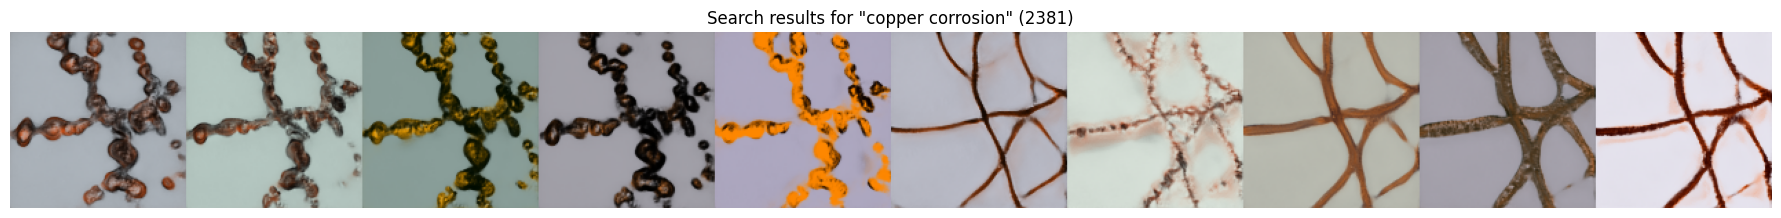

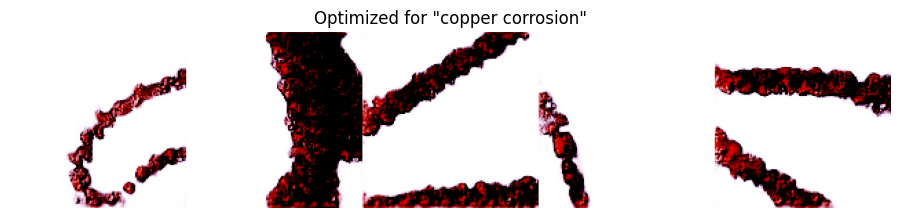

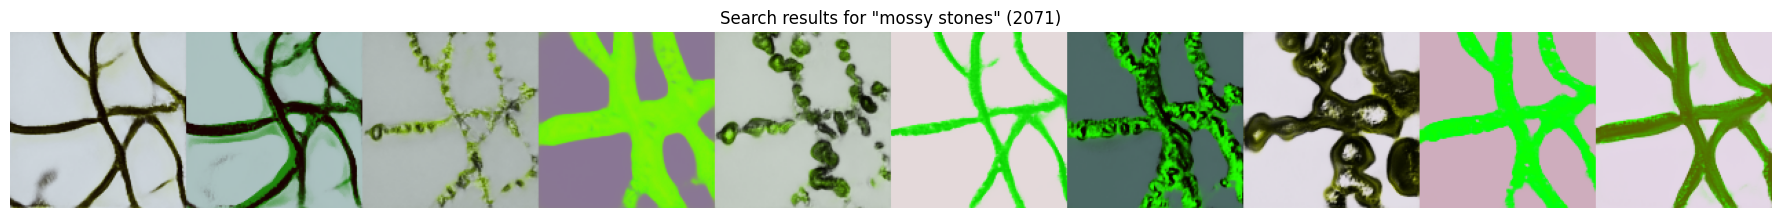

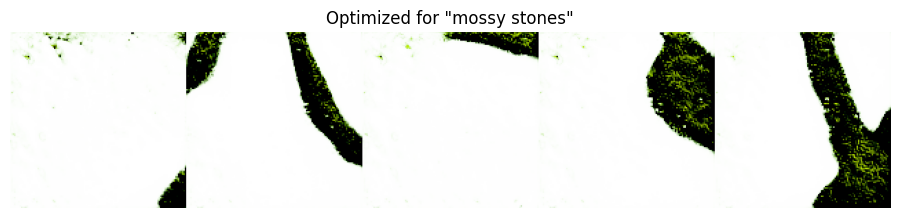

In [4]:
exp_dir = os.path.join(REPO_ROOT, 'experiments', 'clip', '{STYLE}')
viz_dir = os.path.join(exp_dir, 'viz')
os.makedirs(viz_dir, exist_ok=True)

num_steps = 200
save_interval = 25
pkl = os.path.join(exp_dir, 'clip_results_%d.pkl' % num_steps)
logger.info(f'Writing results to {pkl}')

queries = ["copper corrosion", "mossy stones"]
for qidx, q in enumerate(queries):
    qname = re.sub("[^0-9a-zA-Z]+", "_", q)
    
    print(f'Searching for closest known style to query "{q}"')
    res_seeds = feat_dict.get_top_results(q)
    quick_viz_search_results(res_seeds).set_title('Search results for "%s" (%s)' %(q, res_seeds[0]))
    
    brush_options = forger.ui.brush.GanBrushOptions()
    seed_library.set_style(res_seeds[0], brush_options)
    start_z = brush_options.style_z.to(device)
    
    print(f'Optimizing for "{q}"')
    result, frames = clip_optimizer.optimize(q, resume_from_z=start_z, num_steps=num_steps, output_video=True, iou_weight=0.8, return_result_every_n=save_interval, video_output_interval=save_interval, on_white=True)
    quick_viz(frames[-1]).set_title(f'Optimized for "{q}"')
    clip_optimizer.write_to_pickle(pkl, q, result, overwrite=True) 
            
